In [7]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

In [8]:
# by default it is assumed that at least one CUDA-capable NVIDIA GPU is available
if torch.cuda.is_available():
    start_run(config_file=Path("1_basin.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("1_basin.yml"), gpu=-1)

2024-08-02 09:56:17,353: Logging to /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/runs/test_run_0208_095617/output.log initialized.
2024-08-02 09:56:17,354: ### Folder structure created at /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/runs/test_run_0208_095617
2024-08-02 09:56:17,354: ### Run configurations for test_run
2024-08-02 09:56:17,354: experiment_name: test_run
2024-08-02 09:56:17,355: train_basin_file: 1_basin.txt
2024-08-02 09:56:17,355: validation_basin_file: 1_basin.txt
2024-08-02 09:56:17,355: test_basin_file: 1_basin.txt
2024-08-02 09:56:17,355: train_start_date: 1970-10-01 00:00:00
2024-08-02 09:56:17,355: train_end_date: 2018-09-30 00:00:00
2024-08-02 09:56:17,355: validation_start_date: 1955-10-01 00:00:00
2024-08-02 09:56:17,356: validation_end_date: 1965-09-30 00:00:00
2024-08-02 09:56:17,356: test_start_date: 1965-10-01 00:00:00
2024-08-02 09:56:17,356: test_end_date: 1970-09-30 00:00:00
2024-08-02 09:56:17,356: device: cuda:0
2024-08-02 09:56:17,356: valid

### Evaluate run on test set

In [9]:
# Set the directory for model evaluation. This directory is dynamically generated and includes the date
# and time at the start of the model run. Users must specify `run_dir` based on the actual directory
# name created during the run. The directory naming convention typically reflects the date and time of
# the model execution, as shown below. By default, the evaluation will occur on the same device used
# during training.

run_dir = Path("runs/test_run_0208_095617")  # Example path to the dynamically created run directory.
eval_run(run_dir=run_dir, period="test")  # Initiate model evaluation for the 'test' period.


2024-08-02 09:58:10,808: Using the model weights from runs/test_run_0208_095617/model_epoch050.pt
# Evaluation: 100%|██████████| 5/5 [00:00<00:00, 10.24it/s]
2024-08-02 09:58:11,300: Stored metrics at runs/test_run_0208_095617/test/model_epoch050/test_metrics.csv
2024-08-02 09:58:11,301: Stored results at runs/test_run_0208_095617/test/model_epoch050/test_results.p


### Load and inspect model predictions

In [10]:
# Load the model's test results from a pickle file located in a specified directory. The structure
# of the results file is a nested dictionary, organized as follows:
# - The top-level dictionary has one key for each basin, even if only a single basin was analyzed.
# - Each basin key leads to a sub-dictionary where keys represent the temporal resolution of the data.
#   In this case, '1D' indicates daily data.
# - At this level, the dictionary includes:
#   - An 'xr' key, containing an xarray Dataset with both observations and model predictions.
#   - Additional keys corresponding to each metric specified in the configuration file, holding
#     their respective results.

# Example path to the results file:
results_path = run_dir / "test" / "model_epoch050" / "test_results.p"
with open(results_path, "rb") as fp:
    results = pickle.load(fp)  # Load the results from the pickle file
    
# Print the keys from the loaded results, typically basin identifiers
results.keys()


dict_keys(['DE1', 'DE2', 'DE3', 'DE4', 'DE5'])

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [11]:
results['DE1']['1D']['xr']

<xarray.Dataset>
Dimensions:            (date: 1826, time_step: 1)
Coordinates:
  * date               (date) datetime64[ns] 1965-10-01 ... 1970-09-30
  * time_step          (time_step) int64 0
Data variables:
    discharge_vol_obs  (date, time_step) float32 0.4 0.4 0.32 ... 0.47 0.39 0.85
    discharge_vol_sim  (date, time_step) float32 0.3647 0.3738 ... 0.5686 0.758

Let's plot the model predictions vs. the observations

Text(0.5, 1.0, 'Test period - NSE 0.764')

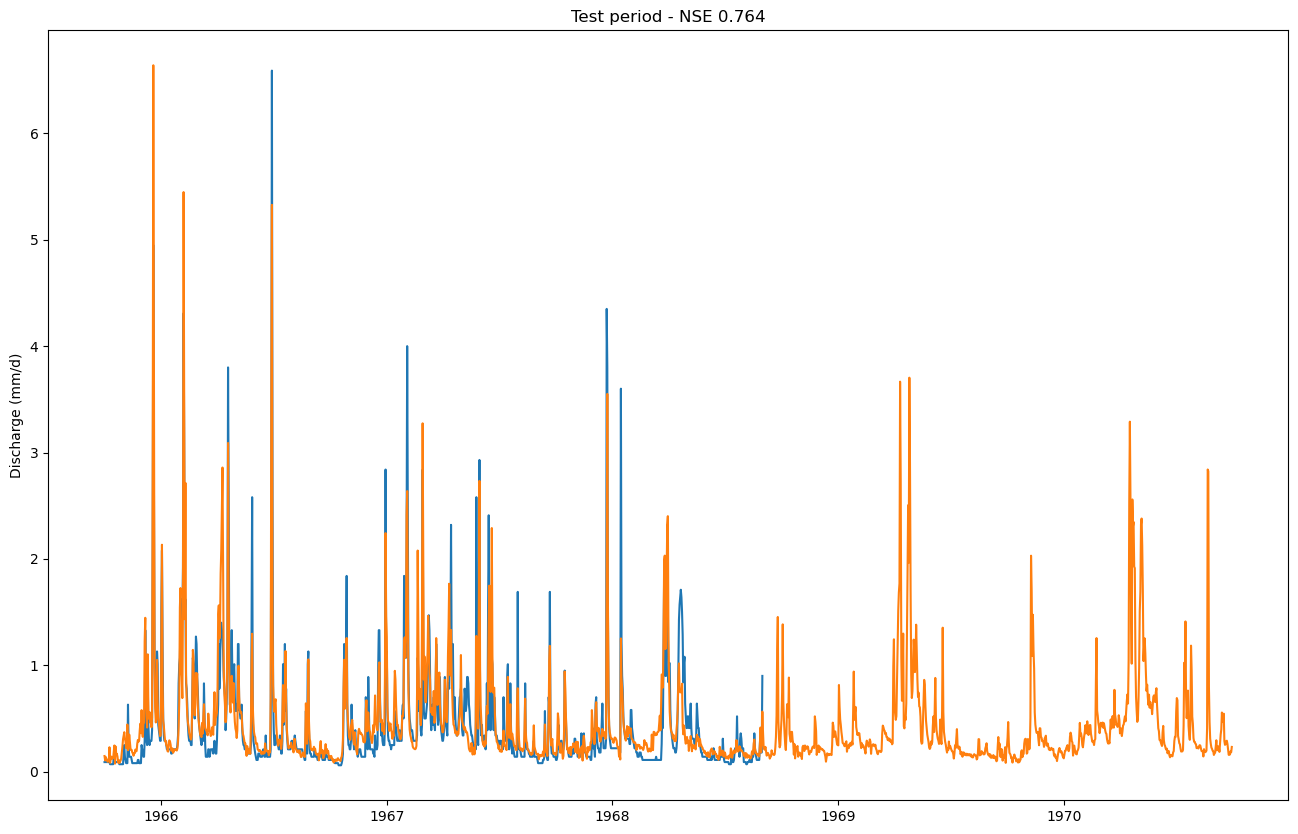

In [15]:
# extract observations and simulations
qobs = results['DE3']['1D']['xr']['discharge_vol_obs']
qsim = results['DE3']['1D']['xr']['discharge_vol_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['DE3']['1D']['NSE']:.3f}")

Compute all metrics that implemented in the NeuralHydrology package. Additional hydrological signatures implemented in `neuralhydrology.evaluation.signatures`.

In [14]:
values = metrics.calculate_all_metrics(qobs.isel(time_step=-1), qsim.isel(time_step=-1))
for key, val in values.items():
    print(f"{key}: {val:.3f}")

NSE: 0.741
MSE: 0.580
RMSE: 0.761
KGE: 0.819
Alpha-NSE: 0.892
Beta-KGE: 1.046
Beta-NSE: 0.029
Pearson-r: 0.862
FHV: -14.047
FMS: 2.932
FLV: -20.736
Peak-Timing: 0.091
Peak-MAPE: 34.654


/home/sngrj0hn/GitHub/neuralhydrology/neuralhydrology/datautils/utils.py:327: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/home/sngrj0hn/GitHub/neuralhydrology/neuralhydrology/datautils/utils.py:368: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
